In [1]:
import time

import IPython.display as IPd
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable

import stg_energy.fig3_amortize_energy.viz as viz
from pyloric import create_prior, get_time, simulate_energyscape, stats
from sbi.utils.regression_net.get_nn_classifier import classifier
from sbi.utils.regression_net.train_classifier import fit_regression_net
from stg_energy.common import col, get_labels_8pt, svg
from stg_energy.fig3_amortize_energy.helper_functions import (
    active_subspace,
    get_gradient,
)
import seaborn as sns
import pandas as pd

# Figure 3

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
PANEL_REG_A1 = "svg/panel_reg_a1.svg"
PANEL_REG_A2 = "svg/panel_reg_a2.svg"
PANEL_REG_B = "svg/panel_reg_b.svg"
PANEL_REG_C = "svg/panel_reg_c.svg"
PANEL_REG_D1 = "svg/panel_reg_d1.svg"
PANEL_REG_D2 = "svg/panel_reg_d2.svg"
PANEL_REG_D3 = "svg/panel_reg_d3.svg"
PANEL_REG_D4 = "svg/panel_reg_d4.svg"
PANEL_REG_E = "svg/panel_reg_e.svg"
PANEL_REG_F = "svg/panel_reg_f.svg"
PANEL_REG_F_alt = "svg/panel_reg_f_alt.svg"
PANEL_REG_G = "svg/panel_reg_g.svg"
PANEL_REG_H = "svg/panel_reg_h.svg"
PANEL_REG_G2 = "svg/panel_reg_g2.svg"
PANEL_REG_H2 = "svg/panel_reg_h2.svg"
PANEL_quality_of_approx_NN = "svg/panel_quality_of_approx_NN.svg"
PANEL_NN_REG = "../../fig4_sensitivity/svg/panel_nn_reg.svg"

### Load experimental data

In [4]:
prior_11 = create_prior(log=True)
dimensions_11 = 31
lims_11 = np.asarray(
    [-np.sqrt(3) * np.ones(dimensions_11), np.sqrt(3) * np.ones(dimensions_11)]
).T

params_mean_11 = prior_11.mean.numpy()
params_std_11 = prior_11.stddev.numpy()

In [5]:
data = np.load("../../results/11deg_post_pred/11_deg_post_pred_close_to_obs.npz")
good_stats = data["sample_stats"]
good_params = data["sample_params"]
good_seeds = data["sample_seeds"]

In [6]:
sample_params = good_params
sample_stats = good_stats
print("There are", len(good_seeds), "datapoints in this dataset")

There are 55043 datapoints in this dataset


In [7]:
sample_stats = data["sample_stats"]
sample_params = data["sample_params"]
sample_seeds = data["sample_seeds"]

In [8]:
energies = sample_stats[:, 21:24]
summed_energies = np.sum(energies, axis=1)

In [9]:
all_fractions = np.load('../../results/fig3_fraction_consumed_currents.npz')['all_fractions']

In [10]:
all_fractions /= np.linalg.norm(all_fractions)

# Panel 0: Fit regression net

In [11]:
energies = torch.as_tensor(energies)
sample_stats = torch.as_tensor(sample_stats)

In [12]:
print(energies.shape)

torch.Size([55043, 3])


In [13]:
num_test = 500

test_params = good_params[:num_test]
train_params = good_params[num_test:]
mean_params = np.mean(train_params, axis=0)
std_params = np.std(train_params, axis=0)

train_params_norm = (train_params - mean_params) / std_params
test_params_norm = (test_params - mean_params) / std_params

In [14]:
train_energy_ABPD = torch.sum(energies[num_test:], dim=1).unsqueeze(1)
test_energy_ABPD = torch.sum(energies[:num_test], dim=1).unsqueeze(1)
mean_energy = torch.mean(train_energy_ABPD)
std_energy = torch.std(train_energy_ABPD)
train_energy_ABPD_norm = (train_energy_ABPD - mean_energy) / std_energy
test_energy_ABPD_norm = (test_energy_ABPD - mean_energy) / std_energy

In [15]:
nn = classifier(dim=31)

In [16]:
# converged_nn = fit_regression_net(
#     nn,
#     train_params_norm,
#     train_energy_ABPD_norm,
#     num_train=train_params_norm.shape[0],
#     batch_size=50,
#     stop_after_epochs=10,
#     max_epochs=200,
# )
# np.savez('../../results/regression_nets/200923_predict_total_energy_sum_over_all_neurons.npz', converged_nn=converged_nn)

In [17]:
data = np.load(
    "../../results/regression_nets/200923_predict_total_energy_sum_over_all_neurons.npz",
    allow_pickle=True,
)
converged_nn = data["converged_nn"].tolist()

In [18]:
predictions = converged_nn.predict(torch.as_tensor(test_params_norm)).detach()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


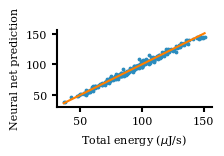

In [19]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.0))
    unnorm_x = test_energy_ABPD_norm[:300] * std_energy + mean_energy
    unnorm_y = predictions[:300] * std_energy + mean_energy
    ax.scatter(x=unnorm_x.numpy()/40000, y=unnorm_y.numpy()/40000, s=3, color="#2b8cbe")
    gt_vec = np.linspace(np.min(unnorm_x.numpy())/40000, np.max(unnorm_x.numpy())/40000, 2)
    ax.plot(gt_vec, gt_vec, "#ff7f00")
    ax.set_xlabel("Total energy ($\mu$J/s)")
    ax.set_ylabel("Neural net prediction")
    plt.savefig(PANEL_quality_of_approx_NN, facecolor='None', transparent=False)

In [20]:
unnorm_y = predictions[:300] * std_energy + mean_energy
mse = torch.mean(torch.abs(unnorm_x/40000 - unnorm_y/40000)**2)
print("mean squared error: ", mse)

mean squared error:  tensor(6.2687, dtype=torch.float64)


In [21]:
e_vals, e_vecs = active_subspace(converged_nn, test_params_norm)

### Plot correlation between parameter and energy

In [22]:
summed_energies / 40000

array([100.91252161,  92.22576264, 136.72640764, ..., 123.69596635,
       132.92566882,  81.11312686])

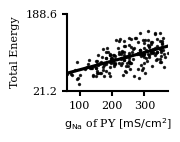

In [23]:
PY_Na = good_params[:, 16]
num_scatter = 200

summed_energies_joule = summed_energies / 40000
df = pd.DataFrame(data=[PY_Na[:num_scatter], summed_energies_joule[:num_scatter]], index=["PY_Na", "total_energy"])

with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(1.3,1.0))
    sns.regplot(x=PY_Na[:num_scatter]*1000, y=summed_energies_joule[:num_scatter], scatter_kws={"s":2}, ci=None, color='k');
    ax.set_xlabel('$\mathrm{g}_{\mathrm{Na}}$ of PY [$\mathrm{mS}/\mathrm{cm}^2$]')
    ax.set_ylabel('Total Energy')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.xaxis.set_label_coords(0.5, -0.35)
    ax.set_ylim([np.min(summed_energies_joule), np.max(summed_energies_joule)])
    ax.set_yticks([np.min(summed_energies_joule), np.max(summed_energies_joule)])
#     ax.set_yticklabels(["min", "max"])
    plt.savefig(PANEL_REG_A1, facecolor='None', transparent=False)

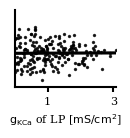

In [24]:
ABPD_Na = good_params[:, 20]

with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(1.3,1))
    sns.regplot(x=ABPD_Na[:num_scatter]*1000, y=summed_energies_joule[:num_scatter], scatter_kws={"s":2}, ci=None, color='k');
    ax.set_xlabel('$\mathrm{g}_{\mathrm{KCa}}$ of LP [$\mathrm{mS}/\mathrm{cm}^2$]')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim([np.min(summed_energies_joule), np.max(summed_energies_joule)])
    ax.set_yticks([np.min(summed_energies_joule), np.max(summed_energies_joule)])
#     ax.set_yticklabels(["min", "max"])
    ax.set_yticks([])
    ax.set_xticks([1, 3])
    plt.savefig(PANEL_REG_A2, facecolor='None', transparent=False)

### Sketch of active subspace

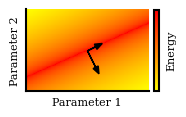

In [25]:
from matplotlib.colors import Normalize
import matplotlib.cm

figureratio = 1.5
figuresize = 1.15

vec1 = np.linspace(-3,3,int(figureratio * 100))
vec2 = np.linspace(-3,3,100)

X,Y = np.meshgrid(vec1, vec2)
dist = np.abs(X + 1.5*Y)

m_e = [0.0, -.1]
s_e = [6., 0.7]
m_e_2 = [1.1, 1.7]
s_e_2 = [1.5, 6.]
dists_e_1 = s_e[0]*(X-m_e[0])**2 + s_e[1]*(Y-m_e[1])**2
dists_e_2 = s_e_2[0]*(X-m_e_2[0])**2 + s_e_2[1]*(Y-m_e_2[1])**2
dists_e = np.minimum(dists_e_1, dists_e_2)
allowed_dist = 5.0
thr_dists_e = dists_e < allowed_dist
inds = np.where(np.abs(dists_e - allowed_dist) < 0.5)
inds = np.asarray(inds).T
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(figureratio*figuresize,figuresize))\

    image_to_plot = -np.sqrt(dist)

    im = ax.imshow(image_to_plot, cmap='autumn_r')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("Parameter 1")
    ax.set_ylabel("Parameter 2")

    cbar = plt.colorbar(im, aspect=15,fraction=0.04, pad=0.04)
    cbar.set_ticks([])
    cbar.set_label('Energy', labelpad=5)
    ax.arrow(75, 50, 10, -5, head_width=7, head_length=9, facecolor='k')
    ax.arrow(75, 50, 10, 20, head_width=7, head_length=9, facecolor='k')
    plt.savefig(PANEL_REG_B, facecolor='None', transparent=False)

### Plot all 31D eigenvalues
It seems that energy lies largely in a 1D subspace. As we will show below, within theis subspace, it is possible to optimize both the energy/spike and the number of spikes.

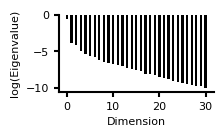

In [26]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.plot_eigenvalues(torch.log(torch.flip(e_vals, dims=(0,))), figsize=(2.0, 1.0), color='k')
    plt.savefig(PANEL_REG_C, facecolor='None', transparent=False)
    plt.show()

In [27]:
print("Ratio of first two eigenvalues:  ", e_vals[-1] / e_vals[-2])

Ratio of first two eigenvalues:   tensor(25.2059)


### Plot first eigenvector

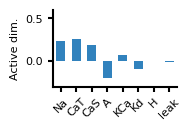

In [28]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.py_sensitivity_bars(e_vecs[0:8, -1:].T, ylim=[-0.3, 0.6], figsize=(1.6, 1.0), ylabel='Active dim.', plot_labels=True, color="#3182bd")
    plt.savefig(PANEL_REG_D1, facecolor='None', transparent=False)
    plt.show()

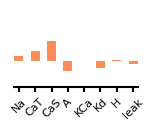

In [29]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.py_sensitivity_bars(e_vecs[8:16, -1:].T, ylim=[-0.3, 0.6], figsize=(1.6, 1.0), ylabel=None, plot_labels=False, color="#fc8d59")
    plt.savefig(PANEL_REG_D2, facecolor='None', transparent=False)
    plt.show()

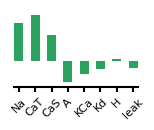

In [30]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.py_sensitivity_bars(e_vecs[16:24, -1:].T, ylim=[-0.3, 0.6], figsize=(1.6, 1.0), ylabel=None, plot_labels=False, color="#2ca25f")
    plt.savefig(PANEL_REG_D3, facecolor='None', transparent=False)
    plt.show()

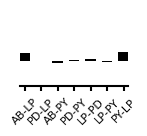

In [31]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.synapse_sensitivity_bars(e_vecs[24:, -1:].T, ylim=[-0.3, 0.6], figsize=(1.4, 1.0), ylabel='', color="k")
    plt.savefig(PANEL_REG_D4, facecolor='None', transparent=False)
    plt.show()

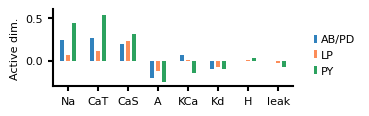

In [36]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.py_sensitivity_bars_cosyne(e_vecs[:, -1].T, ylim=[-0.3, 0.6], figsize=(3.1, 1.0), ylabel='Active dim.', plot_labels=True, color="#2ca25f")
    plt.savefig('svg/panel_all_influences.svg', facecolor='None', transparent=False)
    plt.show()

## Which parameters affect energy, which parameters influence energy?

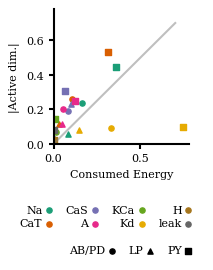

In [34]:
eigenvector = e_vecs[:, -1].numpy()

with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(1.75, 1.75))

    markers = ['o', '^', 's']
    cols_hex = [
        "#1b9e77",
        "#d95f02",
        "#7570b3",
        "#e7298a",
        "#66a61e",
        "#e6ab02",
        "#a6761d",
        "#666666",
    ]
    labels = ['Na', 'CaT', 'CaS', 'A', 'KCa', 'Kd', 'H', 'leak']
    labels2 = ['AB/PD', 'LP', 'PY']
    ims = []
#     for synapse in range(7):
#         im = ax.scatter(
#             all_fractions[24+synapse],
#             np.abs(eigenvector)[24+synapse],
#             c='k',
#             marker='o',
#             s=10
#         )
#     ims.append(im)
    for neuron in range(3):
        for channel, c in enumerate(cols_hex):
            im = ax.scatter(
                    all_fractions[channel+neuron*8], 
                    np.abs(eigenvector)[channel+neuron*8], 
                    c=c, 
                    marker=markers[neuron], 
                    s=14
                )
            if neuron == 0:
                ims.append(im)
    
    # Dummy scatter outside of limits for the legend:
    ims2 = []
    ims2.append(ax.scatter([10.],[10.], c='k', marker='o', s=14))
    ims2.append(ax.scatter([10.],[10.], c='k', marker='^', s=14))
    ims2.append(ax.scatter([10.],[10.], c='k', marker='s', s=14))
    
    leg1 = ax.legend(ims, labels, bbox_to_anchor=(1.05, -0.88, 0.1, 0.5), labelspacing=0.3, columnspacing=0.5, markerfirst=False, handletextpad=-0.4, ncol=4)
    leg2 = ax.legend(ims2, labels2, bbox_to_anchor=(1.05, -1.18, 0.1, 0.5), labelspacing=0.3, columnspacing=0.5, markerfirst=False, handletextpad=-0.4, ncol=3)
    ax.add_artist(leg1)
#     import itertools
#     def flip(items, ncol):
#         return itertools.chain(*[items[i::ncol] for i in range(ncol)])
#     handles, labels = ax.get_legend_handles_labels()
#     ax.legend(flip(handles, 2), flip(labels, 2), bbox_to_anchor=(1.1, -0.9, 0.1, 0.5), labelspacing=0.3, columnspacing=0.5, markerfirst=False, handletextpad=-0.4, ncol=4)

#     ax.arrow(0.6, 0.2, 0.08, -0.065, head_width=0.04, head_length=0.04, facecolor='k')
#     ax.arrow(0.178, 0.645, 0.08, -0.065, head_width=0.04, head_length=0.04, facecolor='k')
#     ax.arrow(0.07, 0.48, 0.0, -0.1, head_width=0.04, head_length=0.04, facecolor='k')
    
    ax.plot([0.0, 0.7], [0.0, 0.7], color='grey', alpha=0.5)
    ax.set_xlim([0.0, 0.78])
    ax.set_ylim([0.0, 0.78])

    ax.set_xlabel('Consumed Energy')
    ax.set_ylabel('|Active dim.|')
    plt.savefig(PANEL_REG_F_alt, facecolor='None', transparent=False)

### Project into 1D plane

In [37]:
num_scatter = 1000

projection_mat = e_vecs[:, -1:]
train_params_norm_tt = torch.as_tensor(train_params_norm)[:num_scatter]
all_train_params_norm_tt = torch.as_tensor(train_params_norm)
projected = torch.mm(train_params_norm_tt, projection_mat)[:num_scatter]
all_projected = torch.mm(all_train_params_norm_tt, projection_mat)

In [38]:
minimal_dim0_set = projected[torch.argmin(projected[:, 0])]
maximal_dim0_set = projected[torch.argmax(projected[:, 0])]

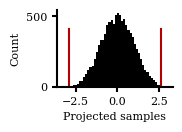

In [39]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.5, 1))
    _ = ax.hist(all_projected[:10000].T, bins=50, facecolor='k')
    ax.axvline(minimal_dim0_set, c="#b30000", ymin=0, ymax=0.75)
    ax.axvline(maximal_dim0_set, c="#b30000", ymin=0, ymax=0.75)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlabel("Projected samples")
    ax.set_ylabel("Count")
    plt.savefig(PANEL_REG_F, facecolor='None', transparent=False)

### Simulate the most extreme cases and show the PY neuron

In [40]:
min_of_energy_PY = torch.min(torch.sum(energies, dim=1)) 
max_of_energy_PY = torch.max(torch.sum(energies, dim=1)) 
print(max_of_energy_PY)

tensor(7542451.3953, dtype=torch.float64)


In [41]:
min_num_spikes_PY = torch.min(torch.sum(sample_stats[:, -6:-3], dim=1)) 
max_num_spikes_PY = torch.max(torch.sum(sample_stats[:, -6:-3], dim=1)) 
print(min_num_spikes_PY)
print(max_num_spikes_PY)

tensor(210., dtype=torch.float64)
tensor(625., dtype=torch.float64)


In [42]:
unnorm_set_dim0_min = (
    train_params_norm_tt[torch.argmin(projected[:, 0])] * std_params + mean_params
)
unnorm_set_dim0_max = (
    train_params_norm_tt[torch.argmax(projected[:, 0])] * std_params + mean_params
)
simulation_output_dim0_min = simulate_energyscape(unnorm_set_dim0_min, seed=0)
simulation_output_dim0_max = simulate_energyscape(unnorm_set_dim0_max, seed=0)

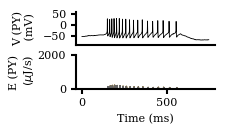

In [43]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.energy_scape(
        simulation_output_dim0_min,
        get_time(),
        (1.8, 1.0),
        ["k", "k", "k"],
        time_len=30000,
        offset=100000,
    )
    plt.savefig(PANEL_REG_G, facecolor='None', transparent=False)
# 18 spikes

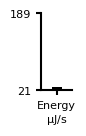

In [44]:
summstats = stats(simulation_output_dim0_min)
energies_PY_sim = np.sum(summstats[28:31])

with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(0.4,1.0))
    height_energy = (energies_PY_sim - min_of_energy_PY) / (max_of_energy_PY - min_of_energy_PY)
    ax.bar(np.arange(0,1), [height_energy], width=0.13, facecolor='k')
    ax.set_ylim([0,1])
    ax.set_xlim([-0.2, 0.2])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([0])
    ax.set_yticks([0,1])
    ax.set_xticklabels(['Energy\n$\mu$J/s'])
    ax.set_yticklabels([21, 189])
    plt.savefig(PANEL_REG_G2, facecolor='None', transparent=False)
    plt.show()

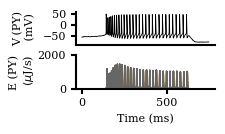

In [45]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    viz.energy_scape(
        simulation_output_dim0_max,
        get_time(),
        (1.8, 1.0),
        ["k", "k", "k"],
        time_len=30000,
        offset=37000,
    )
    plt.savefig(PANEL_REG_H, facecolor='None', transparent=False)
# 29 spikes

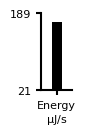

In [46]:
summstats = stats(simulation_output_dim0_max)
energies_PY_sim = np.sum(summstats[28:31])

with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(0.4,1.0))
    height_energy = (energies_PY_sim - min_of_energy_PY) / (max_of_energy_PY - min_of_energy_PY)
    ax.bar(np.arange(0,2), [height_energy], width=0.13, facecolor='k')
    ax.set_ylim([0,1])
    ax.set_xlim([-0.2, 0.2])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([0])
    ax.set_yticks([0,1])
    ax.set_xticklabels(['Energy\n$\mu$J/s'])
    ax.set_yticklabels([21, 189])
    plt.savefig(PANEL_REG_H2, facecolor='None', transparent=False)
    plt.show()